# 1 Model Training

## 1-1 Import Libraries and Files

In [9]:
conda install -c conda-forge lightgbm

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-cpp-1.84.0           |       hca5e981_3          16 KB  conda-forge
    ca-certificates-2025.8.3   |       hbd8a1cb_0         151 KB  conda-forge
    certifi-2025.8.3           |     pyhd8ed1ab_0         155 KB  conda-forge
    conda-24.11.3              |  py312h81bd7bf_0         1.1 MB  conda-forge
    icu-73.2                   |       hc8870d7_0        11.4 MB  conda-forge
    khronos-opencl-icd-loader-2024.10.24|       h5505292_1          34 KB  conda-forge
    libboost-1.84.0            |       h17eb2be_3         1.9 MB  conda-forge
    libboost-devel-1.84.0      |       hf450f58_3          39 KB  conda-forge
    libboost-headers-1.84.0    |     

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import lightgbm as lgb

In [3]:
train_df = pd.read_csv("/Users/yen/Desktop/instacart-reorder-prediction/notebooks/train_df.csv")

## 1-2 Split the Dataset

In [4]:
# Features & target
X = train_df.drop(columns=['reordered'])
y = train_df['reordered']

In [5]:
print(X.dtypes)

user_id                int64
order_id_x             int64
order_id_y             int64
product_id             int64
add_to_cart_order      int64
product_name          object
aisle_id               int64
department_id          int64
aisle                 object
department            object
order_number           int64
order_dow              int64
order_hour_of_day      int64
count                  int64
sum                    int64
reorder_rate_x       float64
total_orders           int64
up_order_count         int64
up_reorder_count       int64
reorder_rate_y       float64
dtype: object


In [6]:
cat_cols = ['product_name', 'aisle', 'department']

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [7]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 1-3 LightGBM

In [12]:
# build the lightgbm model
lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# train the model
lgbm.fit(X_train, y_train)

# predict
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:, 1]  # ROC-AUC

[LightGBM] [Info] Number of positive: 8516840, number of negative: 5932553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2937
[LightGBM] [Info] Number of data points in the train set: 14449393, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.589425 -> initscore=0.361591
[LightGBM] [Info] Start training from score 0.361591


## 1-4 Results and Analysis

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86   2542108
           1       0.88      0.95      0.91   3650490

    accuracy                           0.89   6192598
   macro avg       0.90      0.88      0.89   6192598
weighted avg       0.90      0.89      0.89   6192598


Confusion Matrix:
[[2083497  458611]
 [ 194069 3456421]]

ROC-AUC Score: 0.9633


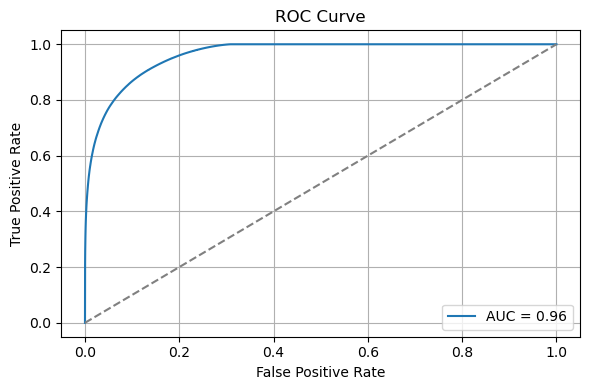

In [13]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

0: negative class, did not reorder
1: positive class, did reorder

precision: prediction==1, reality==1  
recall: reality==1, prediction==1

# 2 Insights

## 2-1 Feature Importance from LightGBM

**The number of times a user purchased a product**(up_order_count) and their **overall order history** (order_number, total_orders) are by far the strongest predictors of reordering behaviour. This highlights that **customer-specific purchasing patterns are more influential than product or departmental characteristics**, indicating that future promotional strategies for boosting reorder rates should focus on the customer.

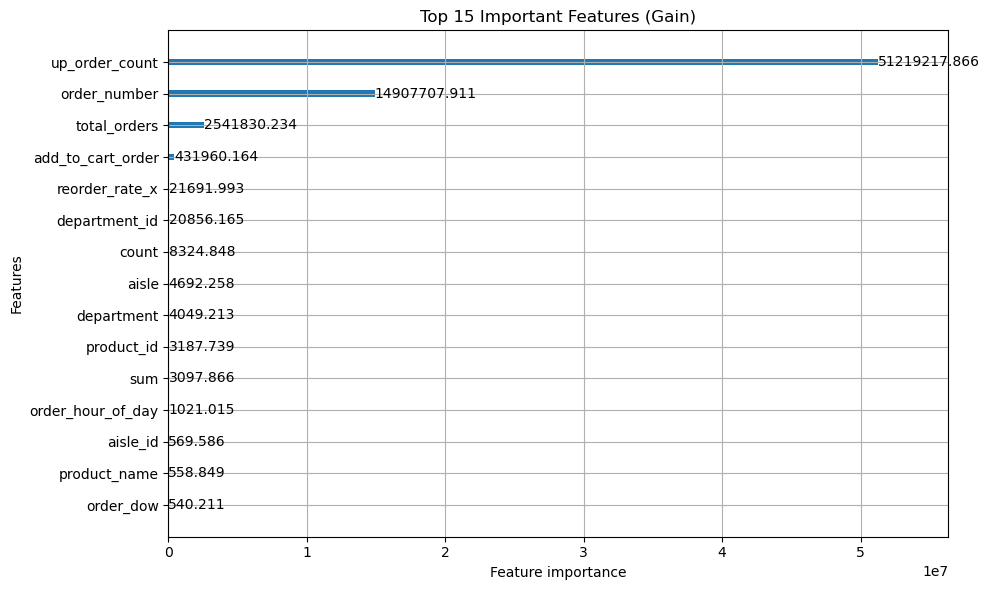

In [17]:
lgb.plot_importance(lgbm, max_num_features=15, importance_type='gain', figsize=(10,6))
plt.title("Top 15 Important Features (Gain)")
plt.tight_layout()
plt.show()

## 2-2 Key Behavioural Patterns

### 2-2-1 Add-to-cart order vs Reorder rate

**Products reordered are typically added earlier in the shopping cart**, suggesting stronger user familiarity and **habitual purchasing**. This behavioural pattern could be leveraged in UI design or product placement strategy to prioritise high-likelihood reorders.

Text(0, 0.5, 'Position in Cart')

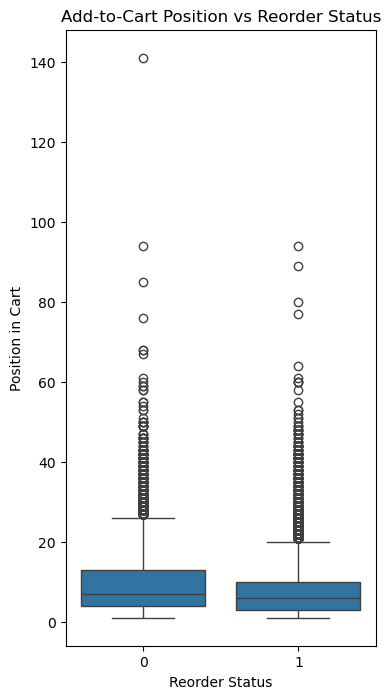

In [25]:
plt.figure(figsize=(4,8))
sns.boxplot(x='reordered', y='add_to_cart_order', data=train_df.sample(50000))
plt.title("Add-to-Cart Position vs Reorder Status")
plt.xlabel("Reorder Status")
plt.ylabel("Position in Cart")

### 2-2-2 Department vs Reorder Rate

Departments such as dairy, beverages, and produce exhibit the highest reorder rates(above 65%), implying these items are considered essential or perishable. Conversely, departments like pantry and personal care show lower reorder rates, indicating more occasional or planned purchases.

Text(0, 0.5, 'Reorder Rate')

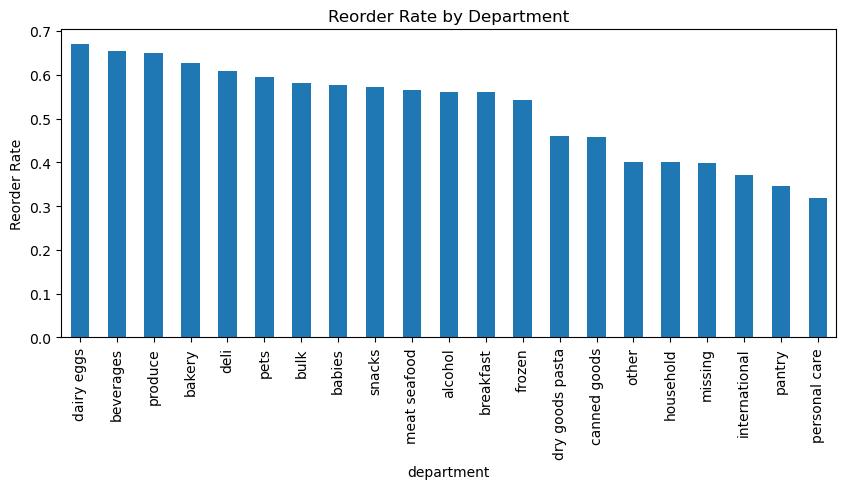

In [19]:
dept_rate = train_df.groupby('department')['reordered'].mean().sort_values(ascending=False)
dept_rate.plot(kind='bar', figsize=(10,4), title="Reorder Rate by Department")
plt.ylabel("Reorder Rate")

## 2-3 Distribution of User Reorder Rate

User reorder behaviour follows a near-normal distribution, with the majority exhibiting a moderate reorder tendency. This suggests a diverse customer base, neither dominated by loyal repurchasers nor entirely composed of one-off buyers, making segmentation and personalised recommendations particularly relevant.

Text(0.5, 1.0, 'Distribution of User Reorder Rate')

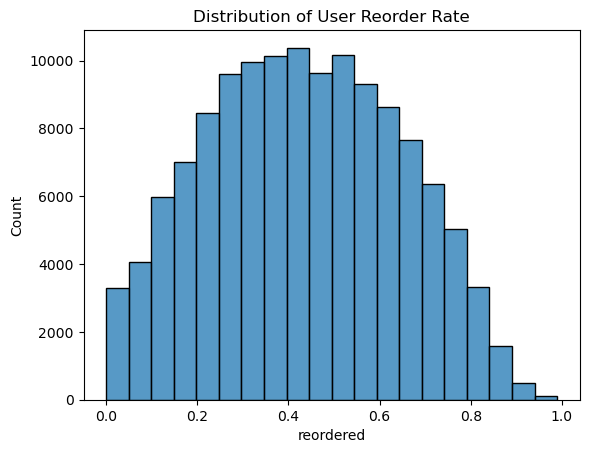

In [20]:
user_reorder_rate = train_df.groupby('user_id')['reordered'].mean().reset_index()
sns.histplot(user_reorder_rate['reordered'], bins=20)
plt.title("Distribution of User Reorder Rate")

## 2-4 Recommendations

- **Introduce "Smart Reorder" buttons** for customers with high reorder consistency. (recurring order)
- **Push frequently reordered products** to the top of personalised shopping lists (based on cart position and reorder rate). (especially to those customers with lower reorder consistency for developing their habit)
- **Promote products from high-reorder departments**, e.g. dairy and produce, in email campaigns. (promote the product generally)
- **Use aisle-level patterns** to create tailored category promotions.

## 2-5 Future Wrok and Limitations

- The model was trained on prior purchase data, without seasonality or promotion information.
- Product names and departments were label-encoded, which may reduce semantic meaning.
- Future work could involve collaborative filtering or time-aware sequence modelling.